<a href="https://colab.research.google.com/github/sonzwon/TIL_DL/blob/master/%5BML%5DClassification_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification

In [1]:
import sklearn
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

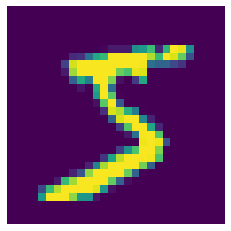

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image)
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [14]:
y = y.astype(np.uint8)

train/test set 분리

In [15]:
#train : test = 60000 : 10000
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

숫자 '5'만 식별해내는 이진분류모형 만들기

### SGDClassifier

In [23]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [22]:
y_train_5  #5만 식별해냄

array([ True, False, False, ...,  True, False, False])

SGDClassifier
- 확률적 결사하강법 학습으로 정규화된 선형모델
    - 손실 기울기는 한번에 각 샘플을 추적하고, 모델은 학습률이 감소되는 방향으로 업데이트 됨
- 대규모 데이터셋에 효율적임
- 온라인 학습이 가능함

In [18]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, 
                        tol=1e-3, 
                        random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [24]:
sgd_clf.predict([some_digit])

array([ True])

#####성능 평가 1) 정확도(교차검증)

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [26]:
# StratifiedKFold 교차검증을 통해 정확도 직접 계산
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred==y_test_fold)
  print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy') #3번의 교차검증

array([0.95035, 0.96035, 0.9604 ])

#####성능 평가 2) 오차행렬

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred) #confusion_matrix(실제값, 예측값)

array([[53892,   687],
       [ 1891,  3530]])

#####성능 평가 3) 정밀도와 재현율

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('정밀도: ', precision_score(y_train_5, y_train_pred))  #precision_score(실제값, 예측값)
print('재현율: ', recall_score(y_train_5, y_train_pred))  #recall_score(실제값, 예측값)
print('F1 score: ', f1_score(y_train_5, y_train_pred))  #f1_score(실제값, 예측값)

정밀도:  0.8370879772350012
재현율:  0.6511713705958311
F1 score:  0.7325171197343846


**Precision&Recall Trade-Off**

In [17]:
# 결정함수
y_score = sgd_clf.decision_function([some_digit])
y_score

array([2164.22030239])

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [33]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

**precision_recall_curve의 return**
- 첫 번째 값들은 정밀도=클래스 균형, 재현율=1.0 
    - 항상 양의 클래스를 예측하는 분류기임
- 마지막에는 정밀도=1., 재현율=0이며, 임계값이 없음

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)  # precision_recall_curve(실제값, 타겟점수)

정밀도:  [0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ]
재현율:  [1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00]
임계값:  [-106527.45300471 -105763.22240074 -105406.2965229  ...   38871.26391927
   42216.05562787   49441.43765905]


In [36]:
print(len(precisions))
print(len(recalls))
print(len(thresholds))

59967
59967
59966


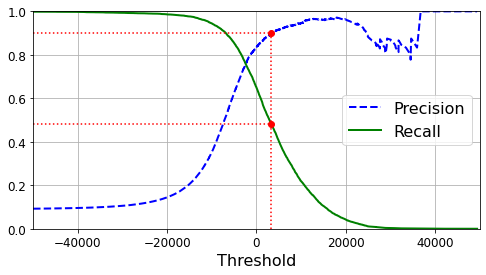

In [44]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])             


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")      

plt.show()

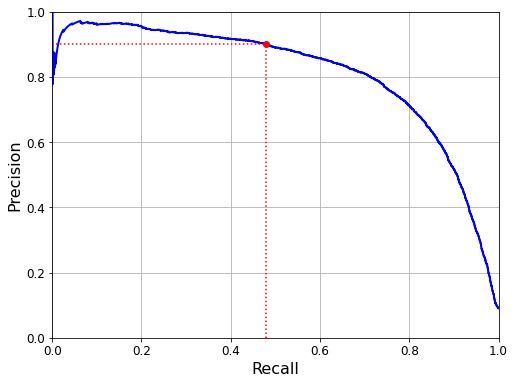

In [45]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [46]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [47]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print('정밀도: ', precision_score(y_train_5, y_train_pred_90))
print('재현율: ', recall_score(y_train_5, y_train_pred_90))

정밀도:  0.9000345901072293
재현율:  0.4799852425751706


#####성능 평가 4) ROC curve

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

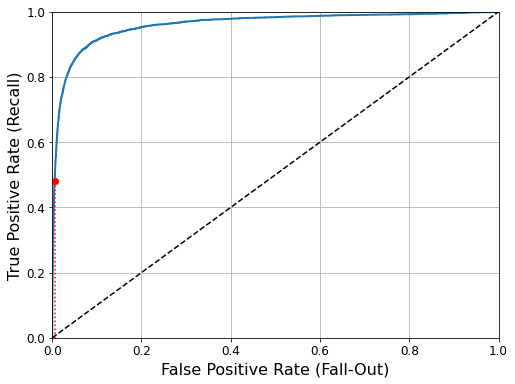

0.9604938554008616

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")                                               
plt.show()

roc_auc_score(y_train_5, y_scores)

### RandomForestClassifier

In [51]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

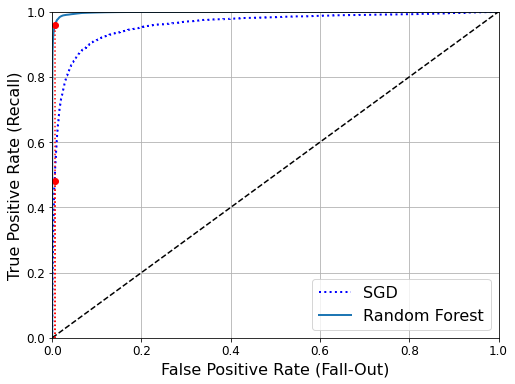

SGDClassifier AUC :  0.9604938554008616
RandomForestClassifier AUC :  0.998402186461512


In [54]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

print('SGDClassifier AUC : ', roc_auc_score(y_train_5, y_scores))
print('RandomForestClassifier AUC : ', roc_auc_score(y_train_5, y_scores_forest))

In [55]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print('RandomForestClassifier Precision : ',precision_score(y_train_5, y_train_pred_forest))
print('RandomForestClassifier Recall : ', recall_score(y_train_5, y_train_pred_forest))

RandomForestClassifier Precision :  0.9905083315756169
RandomForestClassifier Recall :  0.8662608374838591


# Multi-Classification

In [56]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [57]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [58]:
np.argmax(some_digit_scores)

5

In [59]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [60]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(svm_clf)
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [63]:
sgd_clf.fit(X_train[:1000], y_train[:1000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [64]:
sgd_clf.decision_function([some_digit])

array([[-6049581.97985829, -6138036.45541781, -3886281.38604606,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

##### 성능 평가) 정확도(교차검증)

In [65]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

#Classification Error Analysis

In [69]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

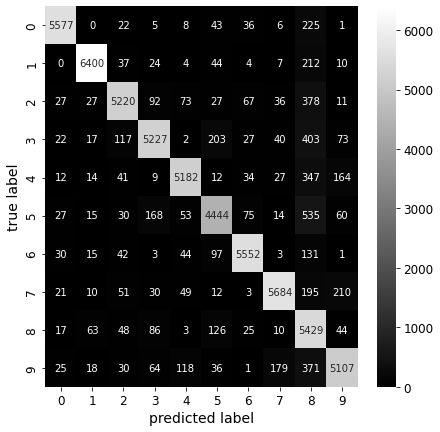


               precision    recall  f1-score   support

           0       0.97      0.94      0.95      5923
           1       0.97      0.95      0.96      6742
           2       0.93      0.88      0.90      5958
           3       0.92      0.85      0.88      6131
           4       0.94      0.89      0.91      5842
           5       0.88      0.82      0.85      5421
           6       0.95      0.94      0.95      5918
           7       0.95      0.91      0.93      6265
           8       0.66      0.93      0.77      5851
           9       0.90      0.86      0.88      5949

    accuracy                           0.90     60000
   macro avg       0.91      0.90      0.90     60000
weighted avg       0.91      0.90      0.90     60000



In [78]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

plt.figure(figsize=(7,7))
sns.heatmap(conf_mx, annot=True, fmt='d', cmap='gray')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

print('\n', classification_report(y_train, y_train_pred))